<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/evaluation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from numpy.random import randn #importing randn
import numpy as np #importing numpy
import matplotlib.pyplot as plt #importing plotting module
import itertools
import warnings

def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours   
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)        
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None:
            conts = list(classes)        
        vmin,vmax = classes[0]-eps,classes[-1]+eps
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None:            
            conts = sorted([-1+eps,0,1-eps])
        
    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)
        
        z = np.reshape(z,(npts,npts)).T        
        
        
        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis(extent)
    
    if Y is not None:        
        for i,y in enumerate(classes):
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 30)     
         
    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')   
    if not hold:
        plt.grid()        
        plt.show()
    return extent

def getExamples(n=100,d=2):
    """
    Generates n d-dimensional normally distributed examples of each class        
    The mean of the positive class is [1] and for the negative class it is [-1]
    """
    Xp = randn(n,d)#+1   #generate n examples of the positie class
    Xp=Xp+1
    Xn1 = randn(int(n/2),d)#-1   #generate n examples of the negative class
    Xn1=Xn1-1
    Xn2 = randn(int(n/2),d)#-1   #generate n examples of the negative class
    Xn2=Xn2+2
    Xn = np.vstack((Xn1,Xn2))  #Stack the examples together to a single matrix
    X = np.vstack((Xp,Xn))  #Stack the examples together to a single matrix
    Y = np.array([+1]*n+[-1]*n) #Associate Labels
    return (X,Y) 

def plotROC(y,z,pstr = ''):
    fpr,tpr,tt = roc_curve(y, z)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(tt,fpr,'o-',tt,tpr,'x-');plt.xlabel('threshold');plt.ylabel('Percentage');plt.legend(['FPR','TPR']);plt.grid();plt.title(pstr)
    plt.figure()
    plt.plot(fpr,tpr,'o-');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.title(pstr+' AUC: '+str(roc_auc))
    return roc_auc
        



In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.metrics import roc_curve, roc_auc_score, auc
X,y = getExamples(n=100)
Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.2, shuffle = True, stratify = None)#, random_state=42)

clf = SVC(C=10.0, kernel='linear',gamma = 1.0) #degree, coef0, gamma='scale',, class_weight=None
clf.fit(Xtr,ytr)
zv = clf.decision_function(Xv)
# calculate the number of true poisitives and false positives at a threshold of t
t = -1000
pred = 2*(zv>t)-1
print('Accuracy',np.mean(pred==yv))
tpr = np.mean((pred==1)*(yv==1))
fpr = np.mean((pred==1)*(yv==-1))
print('TPR:',tpr,'FPR:',fpr)



Accuracy 0.475
TPR: 0.475 FPR: 0.525


In [0]:
# plot fpr and tpr vs. thrshold and roc
roc_tr = plotROC(ytr,clf.decision_function(Xtr),'Training')
roc_v = plotROC(yv,zv,'Validation')

plt.figure()
plotit(X = X, Y = y, clf = clf.decision_function, conts =[-1,0,1], colors = 'random')

print('Training AUC ROC:', roc_tr)
print('Validation AUC ROC:', roc_v)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: The following kwargs were not used by contour: 'label'


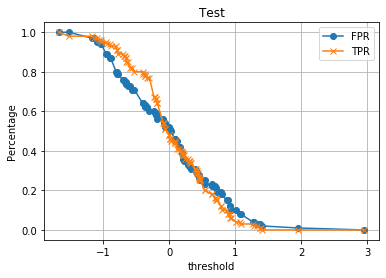

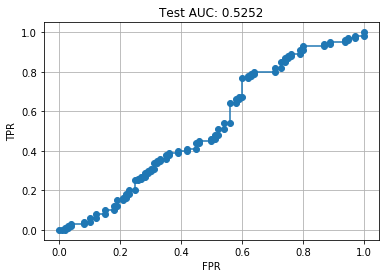

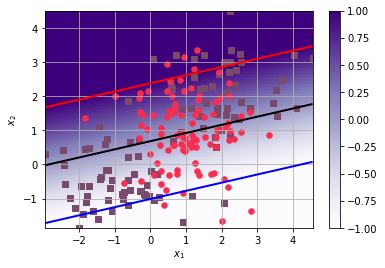

Test AUC ROC: 0.5252


In [52]:
#testing
Xtt,ytt = getExamples(n=100)
roc_tt = plotROC(ytt,clf.decision_function(Xtt),'Test')
plt.figure()
plotit(X = Xtt, Y = ytt, clf = clf.decision_function, conts =[-1,0,1], colors = 'random')

print('Test AUC ROC:', roc_tt)